In [2]:
import sys
sys.path.insert(0, "./src")

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread
import sagemaker
from sagemaker import get_execution_role
import project_utils
%load_ext autoreload

%autoreload 2
%aimport project_utils


In [3]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()


# general prefix
prefix='kaggle-plant-prediction'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

In [5]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

X_train = project_utils.load_images(df_train)

target_classes = ["healthy", "multiple_diseases", "rust", "scab"]

y_train = np.asarray(df_train[target_classes]).argmax(axis=1)

np.savez('./data/training', images=X_train, labels=y_train)
# np.savez('./data/validation', images=x_val, labels=y_val)
# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data('./data/training.npz', bucket=bucket, key_prefix=train_prefix)
#test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [25]:
from sagemaker.tensorflow import TensorFlow

s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

tf_estimator = TensorFlow(entry_point='./src/model.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.p3.2xlarge',
                          framework_version='1.12', 
                          output_path=s3_output_path,
                          py_version='py3'
#                           script_mode=True
#                           hyperparameters={'epochs': 1}
                         )


In [26]:
tf_estimator.fit({"training": train_path})

2020-03-29 11:25:40 Starting - Starting the training job...
2020-03-29 11:25:42 Starting - Launching requested ML instances......
2020-03-29 11:26:46 Starting - Preparing the instances for training......
2020-03-29 11:28:09 Downloading - Downloading input data
2020-03-29 11:28:09 Training - Downloading the training image...
2020-03-29 11:28:35 Training - Training image download completed. Training in progress..2020-03-29 11:28:38,112 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-03-29 11:28:38,441 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir": "s3://sagemaker-eu-central-1-791996542541/kaggle-plant-prediction

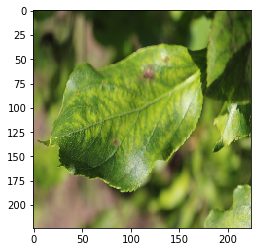

In [15]:
es

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

model = PlantNet(input_shape=(350,250,3))

from tensorflow.keras.utils import to_categorical 


Using TensorFlow backend.



11493376/11490434 [==============================] - 0s 0us/step


In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [15]:
display(df_train.head())
display(df_test.head())

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

# Visual exploration

## Healthy examples

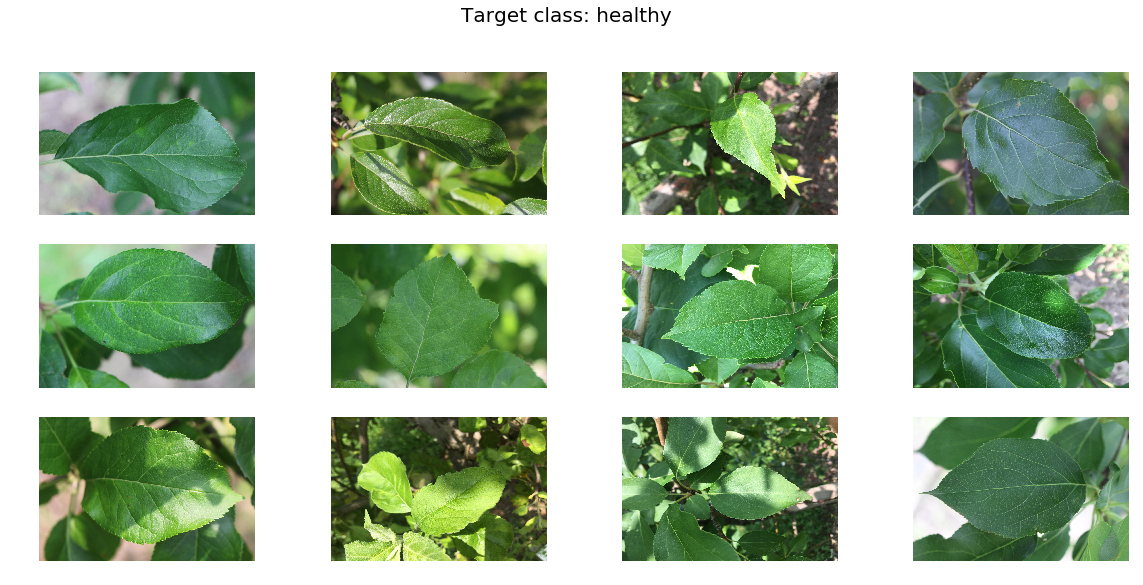

In [63]:
project_utils.plot_examples(df=df_train, _target_class="healthy")

# Rust examples

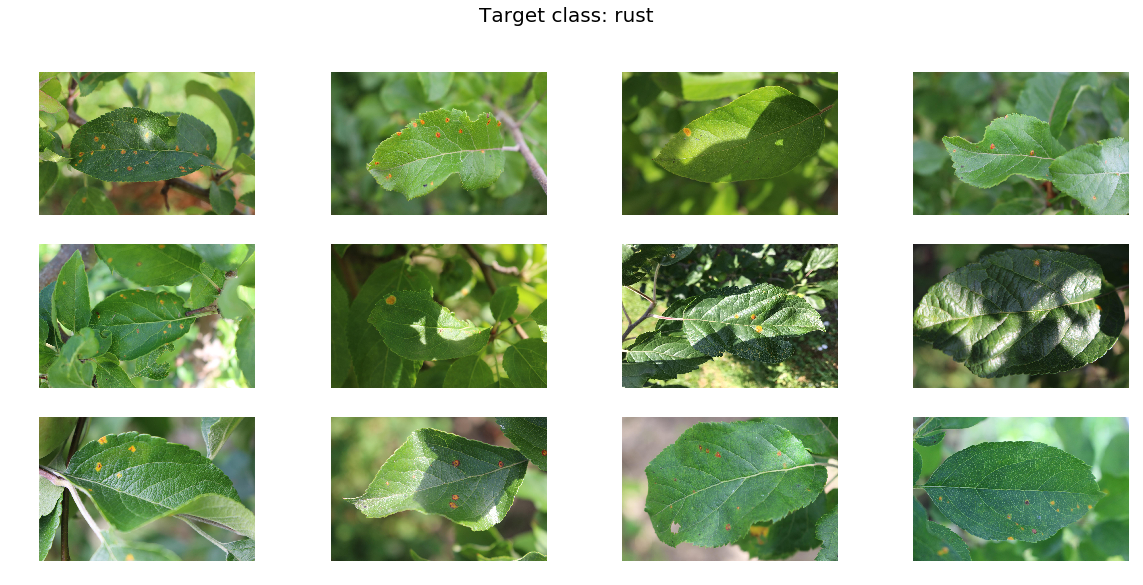

In [64]:
project_utils.plot_examples(df=df_train, _target_class="rust")

## Scab examples

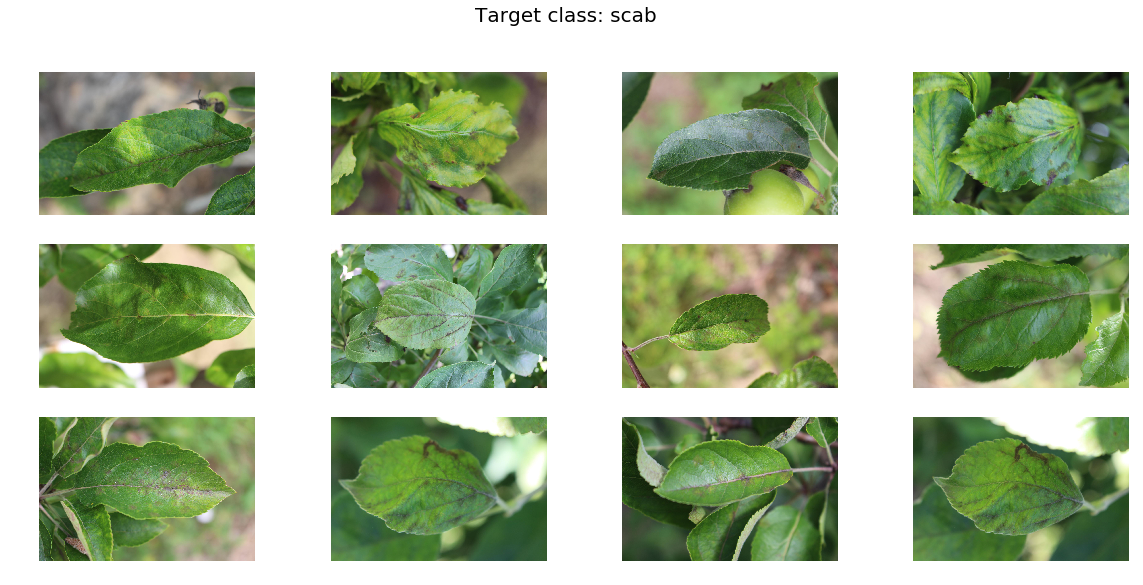

In [55]:
project_utils.plot_examples(df=df_train, _target_class="scab")

## Multiple diseases examples

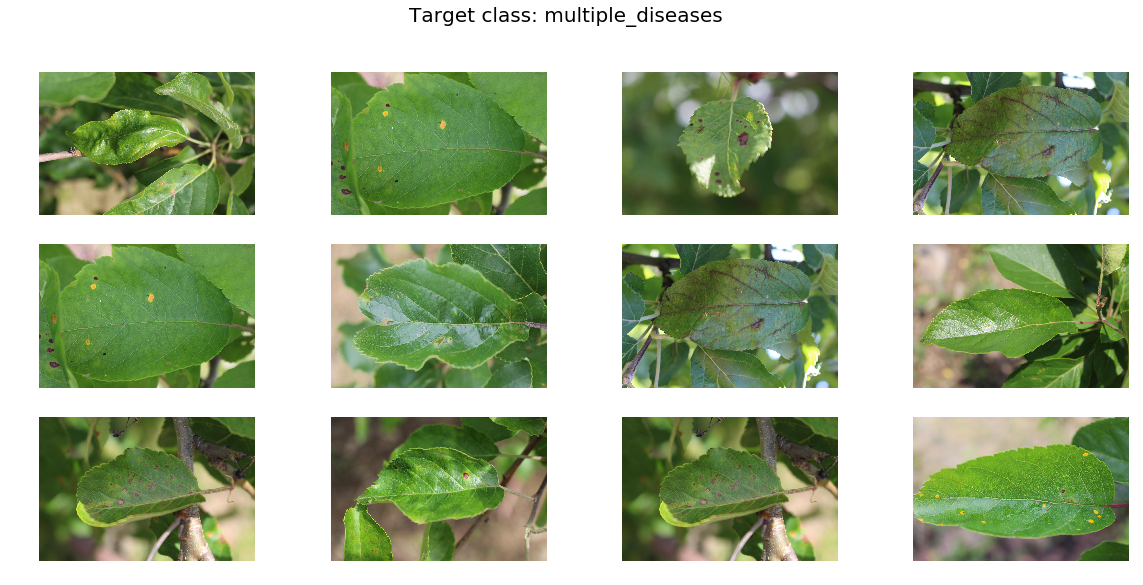

In [56]:
project_utils.plot_examples(df=df_train, _target_class="multiple_diseases")

# Target distribution

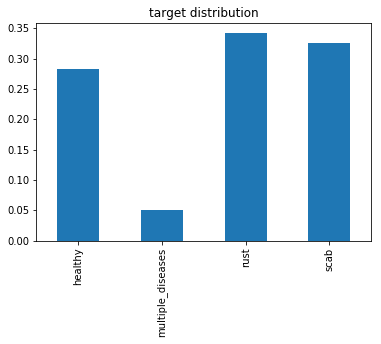

In [23]:
target_classes = ["healthy", "multiple_diseases", "rust", "scab"]

(df_train[target_classes].sum(axis=0) / len(df_train)).plot(kind="bar", title="target distribution")

In [12]:
# To make sure, that each row has only one target class
df_train[target_classes].sum(axis=1).max()

1

# Baseline model

In [16]:
NUM_PATCHES = 50
IMG_SIZE = (10,10)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d
# from skimage.util import view_as_windows
model_nmf = PCA(n_components=25)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [22]:
X_full = project_utils.load_images(df_train)
y_full = np.asarray(df_train[target_classes]).argmax(axis=1)


NameError: name 'target_classes' is not defined

In [24]:
y_full = np.asarray(df_train[target_classes]).argmax(axis=1)


In [44]:
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(px=(1, 16), keep_size=True),
    iaa.Fliplr(0.5),
    iaa.GaussianBlur(sigma=(0, 0.3)),
    iaa.Affine(
            scale={"x": (1, 1.2), "y": (1, 1.2)}, 
            rotate=(-45, 45), 
            shear=(-20, 20)
        )
])

images = X_full
images_aug = seq(images=images)  # done by the library


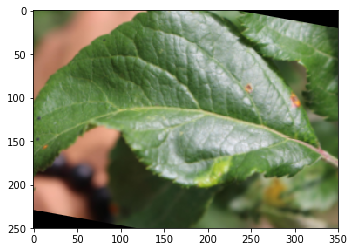

In [45]:
display(plt.imshow(images_aug[23]))


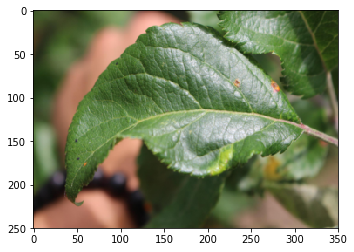

In [46]:
display(plt.imshow(X_full[23]))

In [19]:
patches_list = []

for img in X_full:
    img_patches = list(extract_patches_2d(img.mean(axis=2), IMG_SIZE, max_patches=NUM_PATCHES, random_state=13))
    patches_list += img_patches

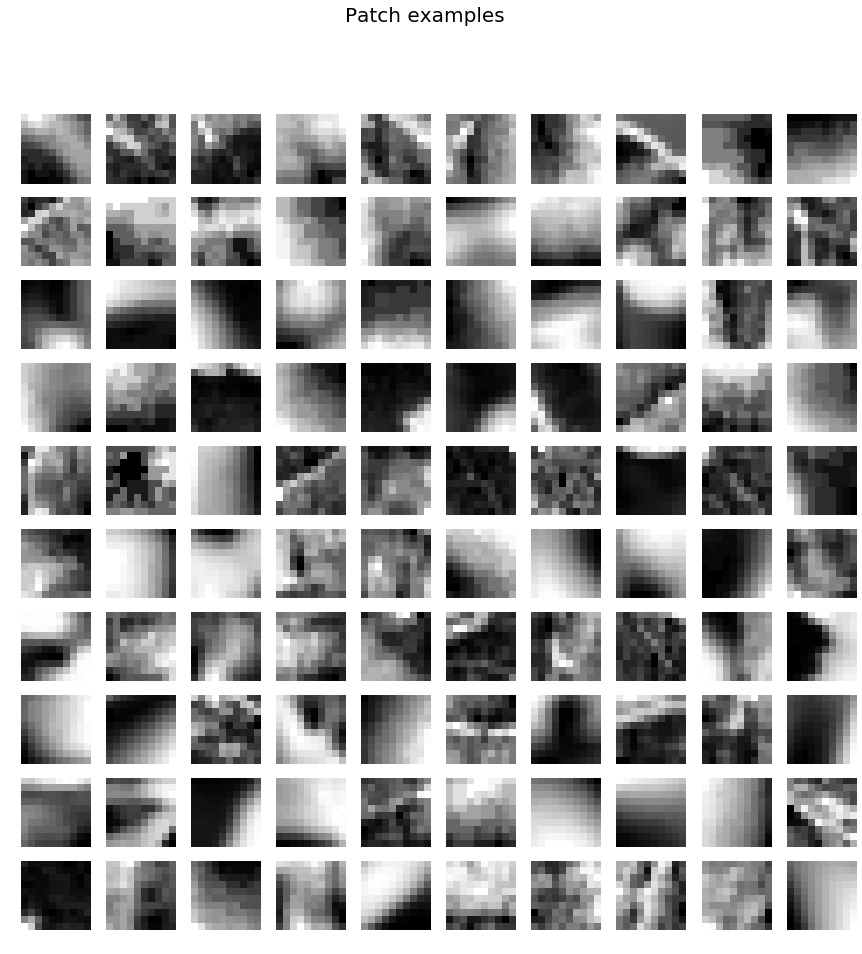

In [20]:
project_utils.plot_patches(patches_list)

In [21]:
patches_list = np.asarray([patch.flatten() for patch in patches_list])


In [368]:
len(patches_list)

182100

In [22]:
patches_transformed = model_nmf.fit_transform(patches_list)

In [23]:
patches_inverse = model_nmf.inverse_transform(patches_transformed)

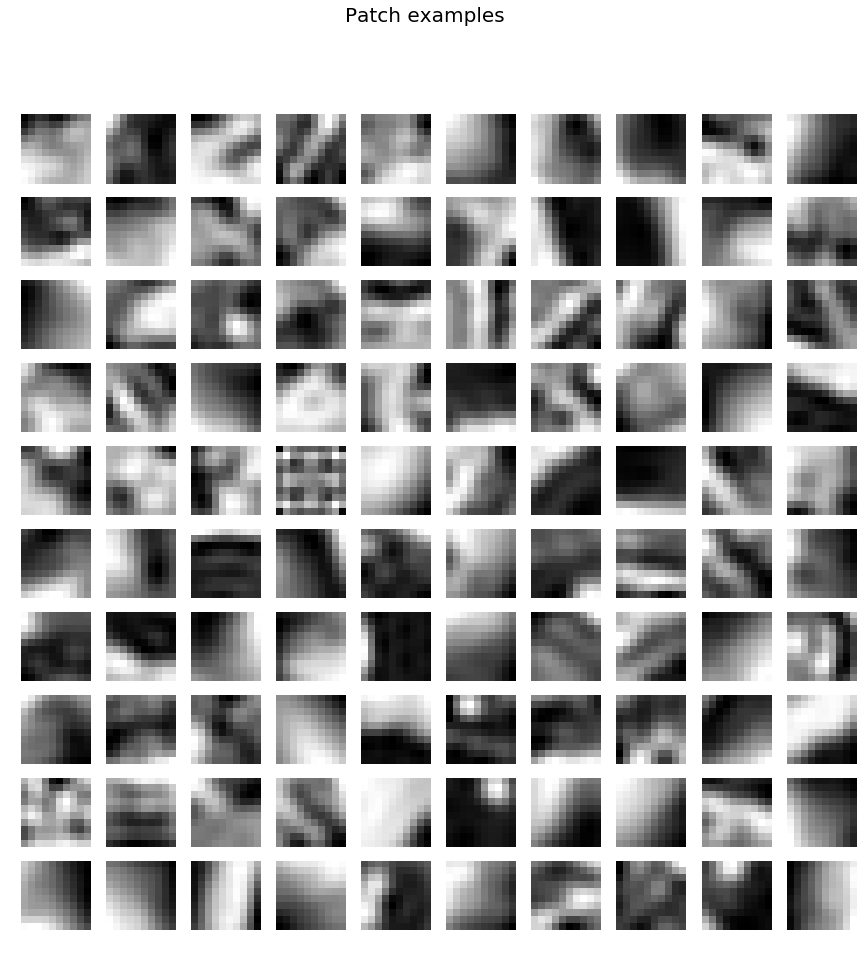

In [24]:
project_utils.plot_patches(patches_inverse.reshape(-1, IMG_SIZE[0], IMG_SIZE[1]))

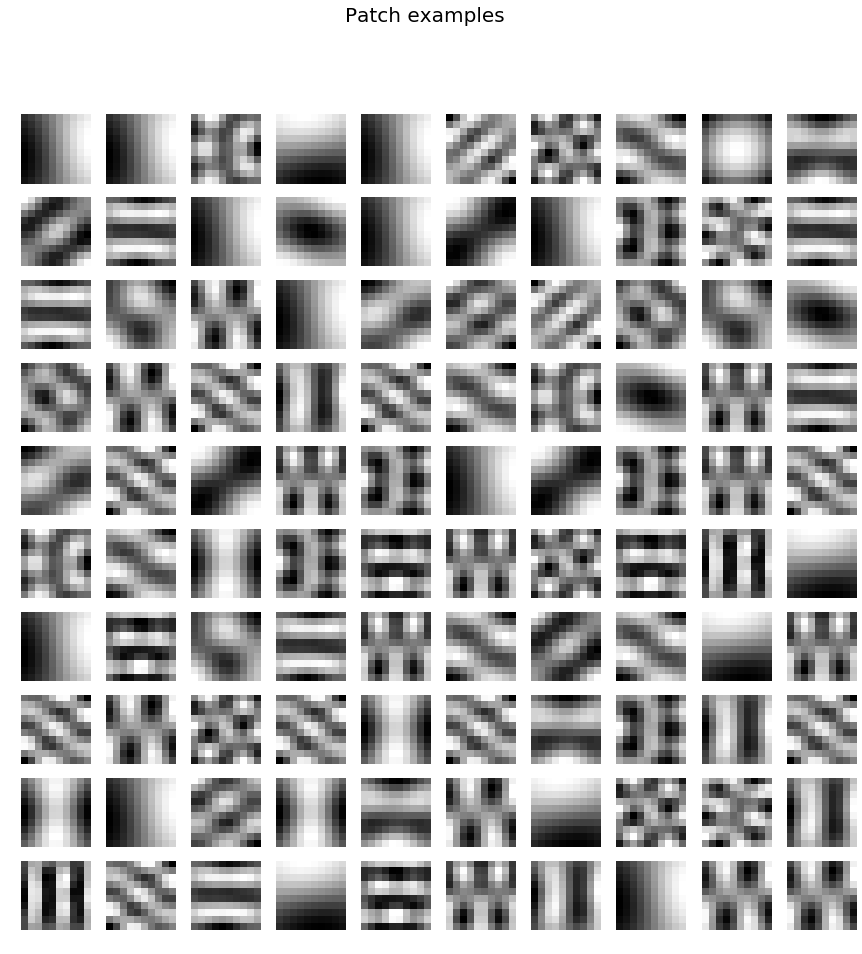

In [25]:
project_utils.plot_patches(model_nmf.components_.reshape(-1, IMG_SIZE[0], IMG_SIZE[1]))

In [394]:
X_train = []

for i in range(0, len(patches_list), NUM_PATCHES):
    X_train.append(model_nmf.transform(patches_list[i:i+NUM_PATCHES]).mean(axis=0))


In [398]:
len(X_test)

547

In [407]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [408]:
model_rf = RandomForestClassifier()

In [409]:
model_rf.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [410]:
display(confusion_matrix(y_test, model_rf.predict(X_test)))

display(accuracy_score(y_test, model_rf.predict(X_test)))

array([[22,  0, 21, 12],
       [ 1,  0,  2,  0],
       [22,  0, 36, 19],
       [14,  1, 26, 30]])

0.42718446601941745

In [ ]:
X_

# Using Sagemaker & Keras for prediction

NameError: name 'df_train' is not defined

NameError: name 'bucket' is not defined

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p3.2xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.